# Principal Component Analysis (PCA)

PCA finds the directions in your data where the points are most spread out (maximum variance), allowing you to summarize high-dimensional data using just a few key axes of variation.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide31.png)

# Key Formula

Let $\mathbf{X}$ be an $N \times P$ data matrix ($N$ observations, $P$ variables). The singular value decomposition of $\mathbf{X}$ can be written as

$$
\mathbf{X} = \mathbf{L} \mathbf{F} + \mathbf{E} = \mathbf{X} \mathbf{V}_k \mathbf{V}_k^T+\mathbf{E}
$$

where:
- $\mathbf{L} = \mathbf{X}\mathbf{V}_k$ is the $N \times k$ **score matrix** (principal component scores/factor scores)
- $\mathbf{F} = \mathbf{V}_k^T$ is the $k \times P$ **loading matrix** (how variables load on components)
- $\mathbf{V}_k$ is the $P \times k$ matrix of the first $k$ eigenvectors of $\mathbf{S} = \frac{1}{N}\mathbf{X}^T\mathbf{X}$
- $\mathbf{E} = \mathbf{X} - \mathbf{X}\mathbf{V}_k\mathbf{V}_k^T$ is the $N \times P$ **reconstruction error** (truncation error)


# Technical Details

## PCA and Factor Analysis

PCA can be considered as a special case of factor analysis with the following constraints:

1. **Orthonormal loadings**: $\mathbf{F}\mathbf{F}^T = \mathbf{V}_k^T\mathbf{V}_k = \mathbf{I}_k$

2. **Uncorrelated scores**: $\frac{1}{N}\mathbf{L}^T\mathbf{L} = \mathbf{\Lambda}_k$ (diagonal matrix of eigenvalues)

3. **Ordered by variance**: $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_k$

4. **Variance maximization**: Subject to orthonormality, this decomposition maximizes the variance captured by the first $k$ components

5. **Minimum reconstruction error**: $\mathbf{E} = \arg\min ||\mathbf{X} - \mathbf{L}\mathbf{F}||_F^2$ subject to $\mathbf{F}\mathbf{F}^T = \mathbf{I}_k$


## Variance Explained

- Total variance: $\text{tr}(\mathbf{S}) = \sum_{i=1}^P \lambda_i$
- Variance captured by $k$ components: $\sum_{i=1}^k \lambda_i$
- Proportion explained: $\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^P \lambda_i}$


# Related Topics

- [Confounders](https://statfungen.github.io/statgen-prerequisites/confounder.html)
- [Genetic Relationship Matrix](https://statfungen.github.io/statgen-prerequisites/genetic_relationship_matrix.html)
- [Proportion of Variance Explained](https://statfungen.github.io/statgen-prerequisites/proportion_of_variance_explained.html)
- [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html)

# Example


Admixture analysis identifies ancestry components in individuals from genetically mixed populations. When populations with distinct genetic backgrounds interbreed over generations, their descendants carry genetic variants from multiple ancestral sources. 

In this example, we'll demonstrate how principal component analysis can be applied to genetic admixture analysis. We'll simulate genotype data for individuals with ancestry from two source populations (e.g., European and East Asian), then use factor analysis to:
1. Identify the number of ancestral populations
2. Estimate individual ancestry proportions (factor scores)
3. Identify ancestry-informative markers (factor loadings)

This setup is the same as we did in [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html) and now we see how PCA solves this.

### Simulate Admixed Genotype Data

We'll create synthetic genotype data where we know the true ancestral populations and individual ancestry proportions.

In [61]:
rm(list=ls())
set.seed(74)

K <- 2   # Number of ancestral populations
I <- 50  # Number of individuals
J <- 10  # Number of markers (SNPs)

# Create F matrix with very distinct population frequencies
F_true <- matrix(0, nrow = K, ncol = J)

# Population 1
F_true[1, ] <- c(0.9, 0.85, 0.95, 0.80, 0.90, 0.15, 0.92, 0.88, 0.2, 0.87)

# Population 2
F_true[2, ] <- c(0.1, 0.15, 0.05, 0.20, 0.10, 0.92, 0.08, 0.18, 0.90, 0.15)

# Add row and column names
rownames(F_true) <- paste0("Pop", 1:K)
colnames(F_true) <- paste0("SNP", 1:J)

Q_true <- matrix(0, nrow = I, ncol = K)

# Individuals 1-15: Pure Pop1
Q_true[1:15, 1] <- 1.0
Q_true[1:15, 2] <- 0.0

# Individuals 16-30: Pure Pop2
Q_true[16:30, 1] <- 0.0
Q_true[16:30, 2] <- 1.0

# Individuals 31-40: Pop1-Pop2 admixture (50-50)
Q_true[31:40, 1] <- 0.5
Q_true[31:40, 2] <- 0.5

# Individuals 41-50: Pop1-Pop2 admixture (30-70)
Q_true[41:50, 1] <- 0.3
Q_true[41:50, 2] <- 0.7

# Add row and column names
rownames(Q_true) <- paste0("Ind", 1:I)
colnames(Q_true) <- paste0("Pop", 1:K)

X_raw <- matrix(0, nrow = I, ncol = J)

for (i in 1:I) {
  for (j in 1:J) {
    # Expected frequency = weighted average of population frequencies
    p_ij <- sum(Q_true[i, ] * F_true[, j])
    
    # Sample genotype (0, 1, or 2 copies)
    X_raw[i, j] <- rbinom(1, size = 2, prob = p_ij)
  }
}

# Add row and column names
rownames(X_raw) <- paste0("Ind", 1:I)
colnames(X_raw) <- paste0("SNP", 1:J)

print("A few rows for the generated raw genotype matrix X_raw:")
head(X_raw,3)

[1] "A few rows for the generated raw genotype matrix X_raw:"


,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10
Ind1,2,2,2,1,1,0,2,1,1,1
Ind2,1,2,1,1,2,0,2,2,0,2
Ind3,2,2,2,2,2,0,2,2,1,2


In [62]:
# Normalize the genotype data
X <- scale(X_raw, center = TRUE, scale = TRUE)

### Perform PCA

In [63]:
# ============================================================
# Perform PCA to detect ancestry structure
# ============================================================

cat("\n============================================\n")
cat("Performing PCA on genotype data\n")
cat("============================================\n\n")

# Perform PCA on standardized genotypes
pca_result <- prcomp(X, center = FALSE, scale. = FALSE)

# Extract PC scores for each individual
pc_scores <- pca_result$x

# Calculate variance explained by each PC
variance_explained <- (pca_result$sdev^2) / sum(pca_result$sdev^2) * 100

cat("Variance explained by top 5 PCs:\n")
for (i in 1:5) {
  cat(sprintf("PC%d: %.2f%%\n", i, variance_explained[i]))
}
cat("\n")

Performing PCA on genotype data

Variance explained by top 5 PCs:
PC1: 56.10%
PC2: 9.52%
PC3: 7.53%
PC4: 6.82%
PC5: 5.70%



### Visualization

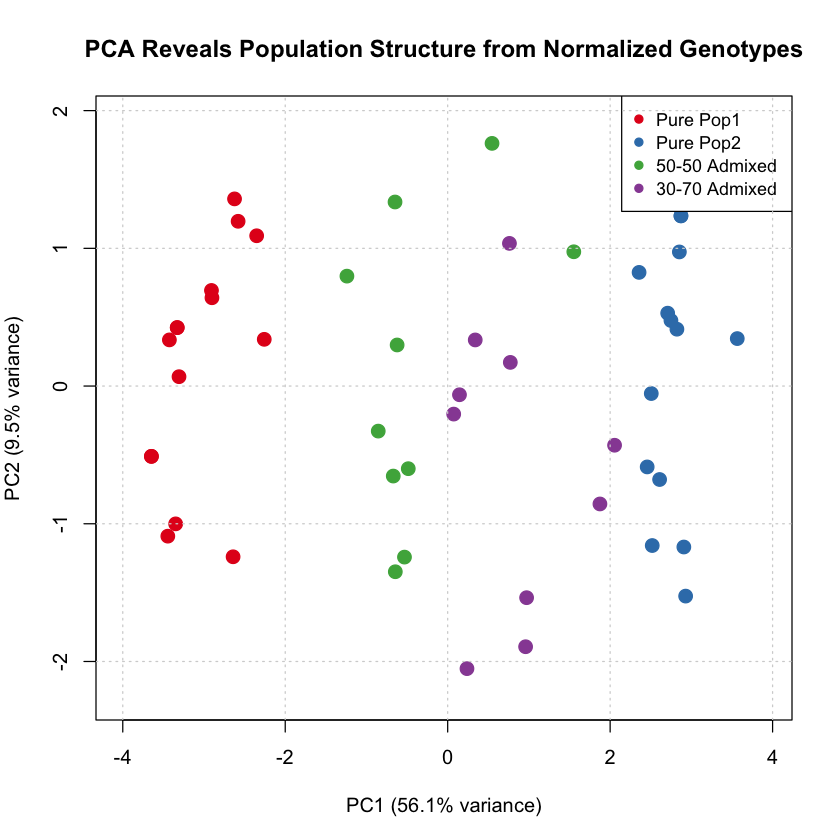

In [64]:
# Define group labels based on true ancestry Q matrix
# Individuals 1-15: Pure Pop1, 16-30: Pure Pop2, 31-40: 50-50 admixed, 41-50: 30-70 admixed
group_labels <- c(rep("Pure Pop1", 15),
                  rep("Pure Pop2", 15),
                  rep("50-50 Admixed", 10),
                  rep("30-70 Admixed", 10))

# Define colors for each group
group_colors <- c("Pure Pop1" = "#E41A1C",
                  "Pure Pop2" = "#377EB8",
                  "50-50 Admixed" = "#4DAF4A",
                  "30-70 Admixed" = "#984EA3")

# Create scatter plot: PC1 vs PC2
par(mfrow = c(1, 1), mar = c(5, 4, 4, 2))

plot(pc_scores[, 1], pc_scores[, 2],
     col = group_colors[group_labels],
     pch = 19, cex = 1.5,
     xlab = sprintf("PC1 (%.1f%% variance)", variance_explained[1]),
     ylab = sprintf("PC2 (%.1f%% variance)", variance_explained[2]),
     main = "PCA Reveals Population Structure from Normalized Genotypes",
     xlim = range(pc_scores[, 1]) * 1.1,
     ylim = range(pc_scores[, 2]) * 1.1)

legend("topright", 
       legend = names(group_colors),
       col = group_colors, 
       pch = 19, 
       cex = 0.9,
       bty = "o")

grid()

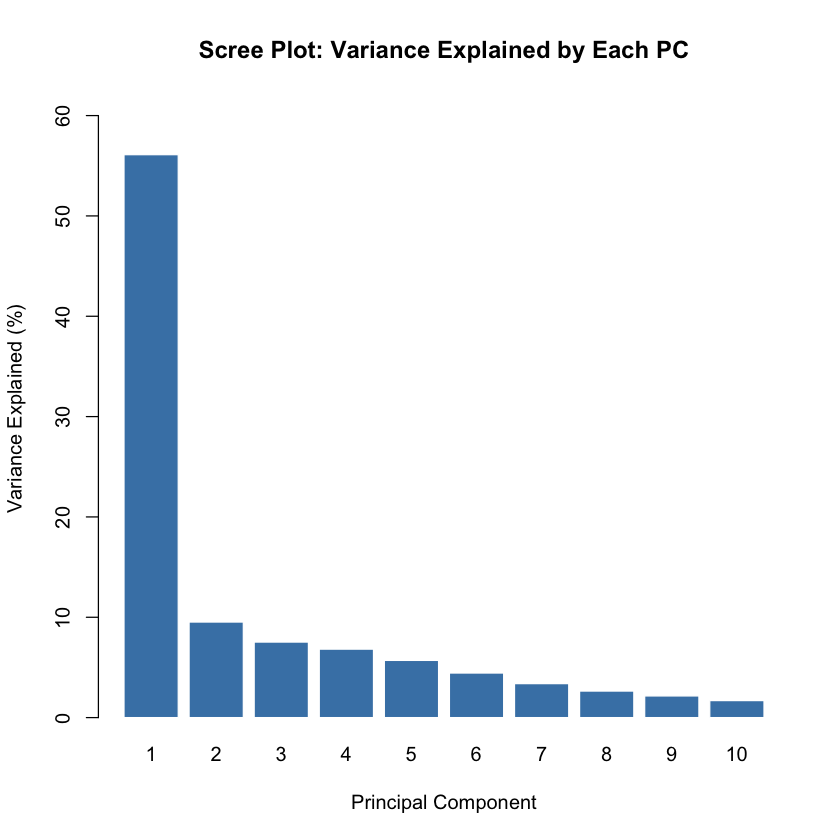

In [65]:
# Create scree plot to show variance explained by each PC
# Barplot of variance explained
barplot(variance_explained[1:10],
        names.arg = 1:10,
        xlab = "Principal Component",
        ylab = "Variance Explained (%)",
        main = "Scree Plot: Variance Explained by Each PC",
        col = "steelblue",
        border = "white",
        ylim = c(0, max(variance_explained[1:10]) * 1.1))

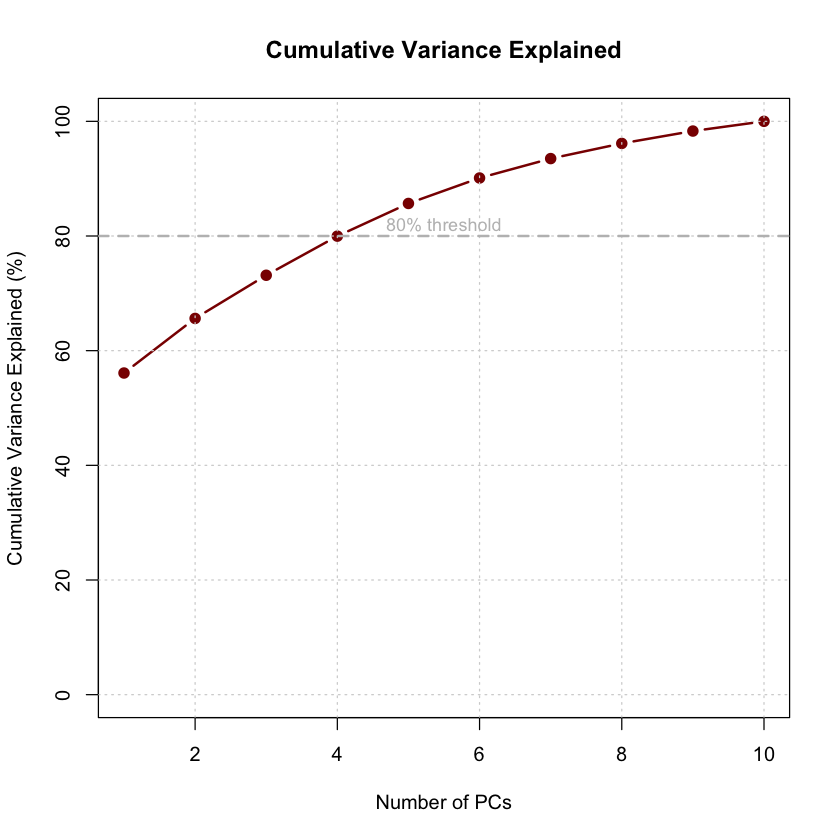

In [66]:
# Cumulative variance explained
cumvar <- cumsum(variance_explained[1:10])
plot(1:10, cumvar,
     type = "b",
     pch = 19,
     col = "darkred",
     lwd = 2,
     xlab = "Number of PCs",
     ylab = "Cumulative Variance Explained (%)",
     main = "Cumulative Variance Explained",
     ylim = c(0, 100))
grid()

# Add reference line at 80% variance
abline(h = 80, col = "gray", lty = 2, lwd = 2)
text(5.5, 82, "80% threshold", col = "gray", cex = 0.9)

Each variant contribute to each PC to a different extent. Here we show the contribution to the first two PCs.

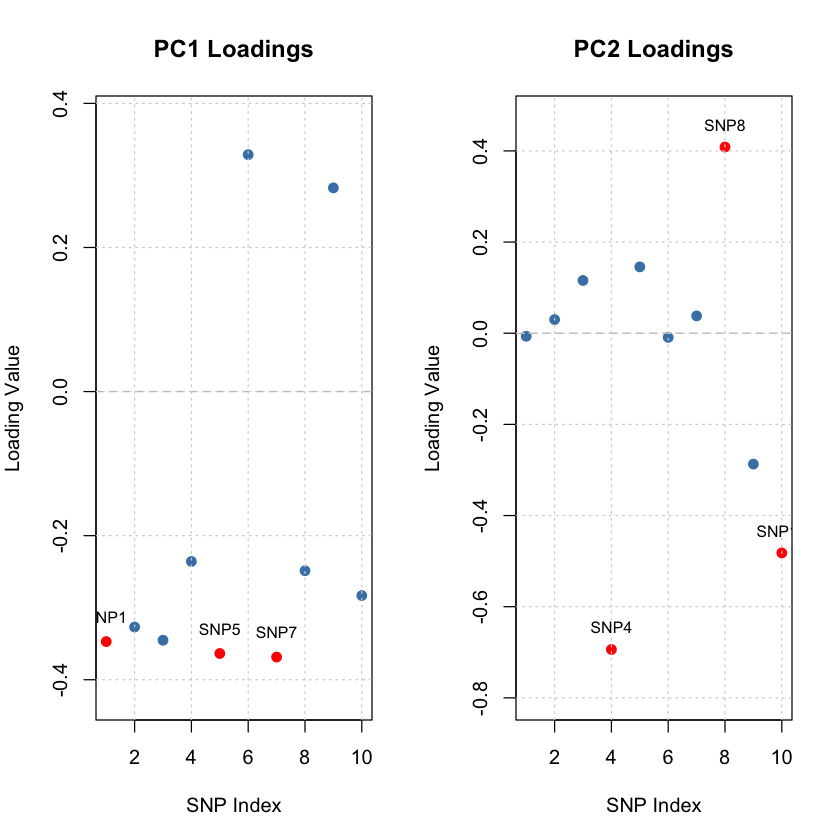

In [67]:
# Extract PC loadings (eigenvectors)
pc_loadings <- pca_result$rotation

# Get PC1 and PC2 loadings
pc1_loadings <- pc_loadings[, 1]
pc2_loadings <- pc_loadings[, 2]

par(mfrow = c(1, 2), mar = c(5, 4, 4, 2))

# Plot PC1 loadings
plot(1:J, pc1_loadings, 
     main = "PC1 Loadings",
     xlab = "SNP Index",
     ylab = "Loading Value",
     pch = 16,
     col = ifelse(abs(pc1_loadings) > quantile(abs(pc1_loadings), 0.75), 
                   "red", "steelblue"),
     cex = 1.2,
     ylim = range(pc1_loadings) * 1.15)
abline(h = 0, col = "gray", lty = 2)
grid()

# Highlight top SNPs by loading magnitude
top_indices <- order(abs(pc1_loadings), decreasing = TRUE)[1:3]
text(top_indices, pc1_loadings[top_indices] + 0.01, 
     colnames(X)[top_indices], cex = 0.8, pos = 3)

# Plot PC2 loadings
plot(1:J, pc2_loadings, 
     main = "PC2 Loadings",
     xlab = "SNP Index",
     ylab = "Loading Value",
     pch = 16,
     col = ifelse(abs(pc2_loadings) > quantile(abs(pc2_loadings), 0.75), 
                   "red", "steelblue"),
     cex = 1.2,
     ylim = range(pc2_loadings) * 1.15)
abline(h = 0, col = "gray", lty = 2)
grid()

# Highlight top SNPs by loading magnitude
top_indices_pc2 <- order(abs(pc2_loadings), decreasing = TRUE)[1:3]
text(top_indices_pc2, pc2_loadings[top_indices_pc2] + 0.01, 
     colnames(X)[top_indices_pc2], cex = 0.8, pos = 3)

# Supplementary

## Graphical Summary


Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha




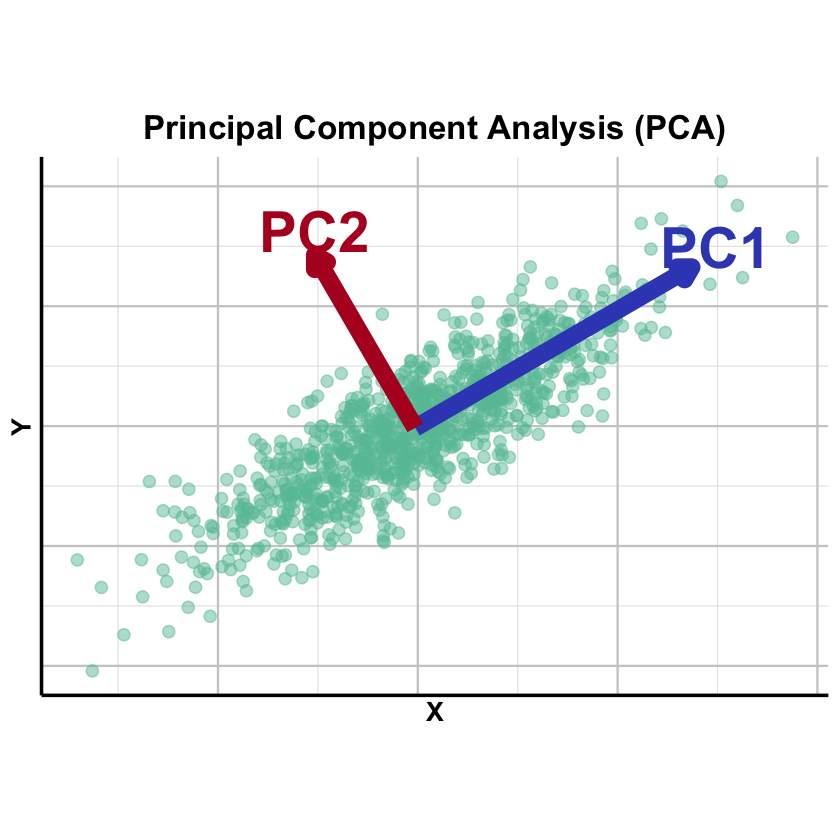

In [68]:
library(ggplot2)

# Set seed for reproducibility
set.seed(42)

# Generate correlated 2D data with PC1 >> PC2
n <- 1000
theta <- pi/6  # 30 degree tilt

# Create elongated cloud - PC1 much longer than PC2
x <- rnorm(n, 0, 3)    # Large variance for PC1 direction
y <- rnorm(n, 0, 0.8)  # Small variance for PC2 direction

# Rotate to create diagonal spread
X_original <- x * cos(theta) - y * sin(theta)
Y_original <- x * sin(theta) + y * cos(theta)

data <- data.frame(X = X_original, Y = Y_original)

# Perform PCA
pca <- prcomp(data, center = TRUE, scale. = FALSE)

# Get PC directions (eigenvectors) - flip if needed
pc1_direction <- -pca$rotation[, 1]  
pc2_direction <- -pca$rotation[, 2]  

# Scale for visualization
scale_factor1 <- 8
scale_factor2 <- 5
pc1_end <- scale_factor1 * pc1_direction
pc2_end <- scale_factor2 * pc2_direction

# Get the center (mean)
center_x <- mean(X_original)
center_y <- mean(Y_original)

# Create the plot
p_PCA <- ggplot(data, aes(x = X, y = Y)) +
  geom_point(color = "#66C2A5", alpha = 0.5, size = 3) +
  
  # PC1 arrow (blue) - use annotate instead of geom_segment
  annotate("segment", 
           x = center_x, y = center_y, 
           xend = center_x + pc1_end[1], 
           yend = center_y + pc1_end[2],
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           color = "#3B4CC0", linewidth = 5) +
  annotate("text", x = center_x + pc1_end[1] + 0.6, 
           y = center_y + pc1_end[2] + 0.5, 
           label = "PC1", color = "#3B4CC0", size = 12, fontface = "bold") +
  
  # PC2 arrow (purple) - use annotate instead of geom_segment
  annotate("segment", 
           x = center_x, y = center_y, 
           xend = center_x + pc2_end[1], 
           yend = center_y + pc2_end[2],
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           color = "#B40426", linewidth = 5) +
  annotate("text", x = center_x + pc2_end[1], 
           y = center_y + pc2_end[2] + 0.6, 
           label = "PC2", color = "#B40426", size = 12, fontface = "bold") +
  
  # Styling
  labs(title = "Principal Component Analysis (PCA)",
       x = "X", y = "Y") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text = element_blank(),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_line(color = "gray90"),
    axis.line = element_line(color = "black", linewidth = 1),
    plot.background = element_rect(fill = "transparent", color = NA),
    panel.background = element_rect(fill = "transparent", color = NA)
  ) +
  coord_fixed(ratio = 1)
  
# Save with transparent background
ggsave("./cartoons/PCA.png", plot = p_PCA, width = 18, height = 12, 
       units = "in", dpi = 300, bg = "transparent")

print(p_PCA)